In [2]:
#!pip install yfinance
#!pip install hmmlearn
#pip install scipy
from sklearn.mixture import GaussianMixture
import yfinance as yf
import numpy as np
from numpy import random
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import hmmlearn as hmm
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

# Importing data

In [177]:
ticker = "^GSPC"  # S&P 500 index symbol

data = yf.download(ticker, start="1950-03-01", end="2024-01-11", interval="1d")

#data = data[data['Open'] != 0]
#data.loc[(data['Open'] == 0) & (data.index >= '1961-12-29') & (data.index <= '1982-04-20'), 'Open'] = np.nan
# 1961 dec 29 until april 20 1982 issues with Open

data.dropna(inplace=True)
data.to_csv('daily_data.csv', sep=';')

data.loc[:, 'Date'] = data.index
data = data.resample('MS', on='Date').mean()  # Monthly averages on the 1st of the month
data.to_csv('monthly_data.csv', sep=';')

[*********************100%%**********************]  1 of 1 completed


# Summary Statistics

In [179]:
descriptive_stats = {
    "Price": ["Open", "High", "Low", "Close"],
    "Min": [data['Open'].min(), data['High'].min(), data['Low'].min(), data['Close'].min()],
    "Max": [data['Open'].max(), data['High'].max(), data['Low'].max(), data['Close'].max()],
    "Mean": [data['Open'].mean(), data['High'].mean(), data['Low'].mean(), data['Close'].mean()],
    "Std.": [data['Open'].std(), data['High'].std(), data['Low'].std(), data['Close'].std()],
}

summary_table = pd.DataFrame(descriptive_stats)
summary_table = summary_table.round(2)
summary_table.to_csv('summary_table.csv', index=False, sep=';')
summary_table

,Price,Min,Max,Mean,Std.
0,Open,0.00,4723.40,763.86,1072.10
1,High,17.35,4750.39,794.49,1060.31
2,Low,17.35,4711.20,784.81,1048.04
3,Close,17.35,4733.86,789.96,1054.56


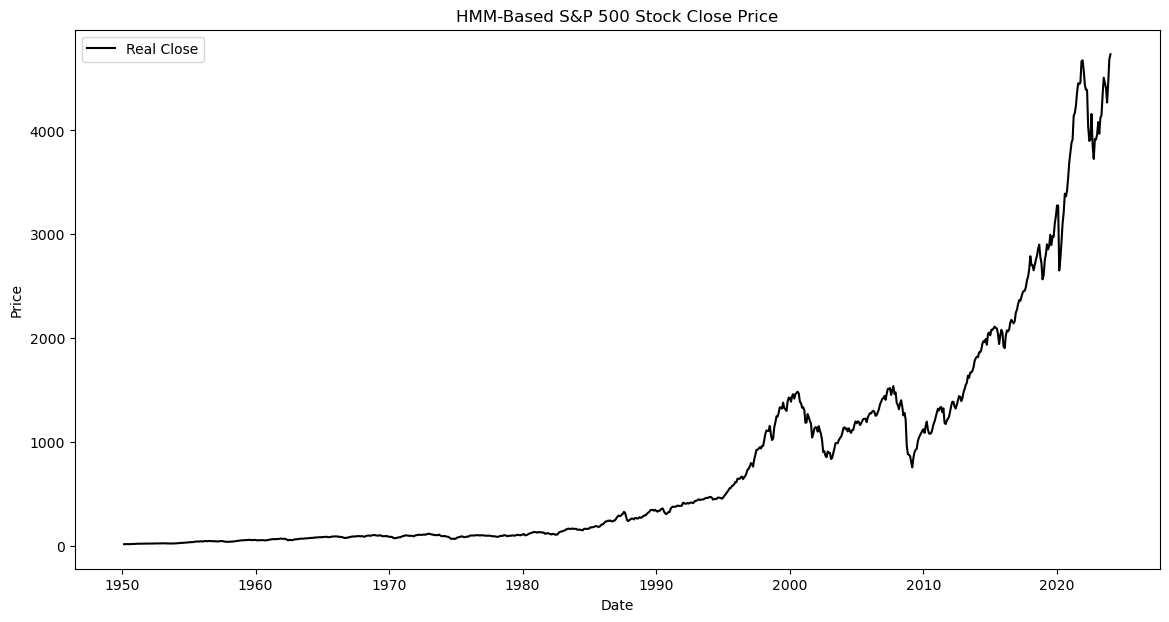

In [207]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Real Close', color='black')
plt.title('HMM-Based S&P 500 Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Model Selection

In [188]:
# Select the first four columns as observations
data = data[data.columns[0:4]]
obs = data.loc["1996-11-01":"2016-11-01"]

# Set the number of observations to consider for each iteration
T = 120

# Initialize empty lists to store the evaluation criteria results
AIC, BIC, HQC, CAIC = [], [], [], []

# Iterate over different number of components for the HMM model
for n in range(2, 7):
    np.random.seed(1)
    # Initialize empty lists to store the evaluation criteria values for each iteration
    a, b, c, d = [], [], [], []

    # Flag to check if it is the first iteration
    first_time = True

    # Iterate over the data with a sliding window of size T
    for i in range(0, T):
        # Define the HMM model
        if first_time:
            # For the first iteration, create a new model
            model = GaussianHMM(n_components=n, n_iter=120)
            first_time = False
        else:
            # For subsequent iterations, create a new model and initialize its parameters
            old_model = model
            model = GaussianHMM(n_components=n, init_params="c", n_iter=120)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

        # Train the model using the Baum-Welch algorithm
        model.fit(obs[i:i+T])

        # Perform the forward algorithm to compute log-likelihoods and forward probabilities
        log_likelihoods, fwd = model.score_samples(obs[i:i+T])

        # Calculate the number of parameters for the model
        k = n**2 + 2*n - 1

        # Calculate AIC (Akaike Information Criterion)
        aic = -2 * log_likelihoods + 2 * k

        # Calculate BIC (Bayesian Information Criterion)
        bic = -2 * log_likelihoods + k * np.log(4 * T)

        # Calculate HQC (Hannan-Quinn Criterion)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))

        # Calculate CAIC (Consistent Akaike Information Criterion)
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        # Append the evaluation criteria values to the corresponding lists
        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    # Append the evaluation criteria lists for the current number of components to the main lists
    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)

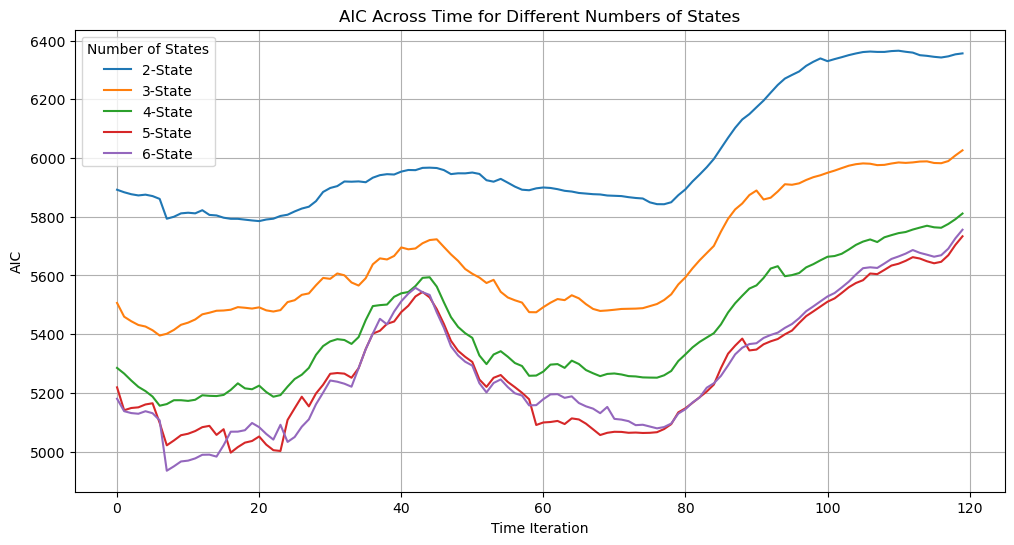

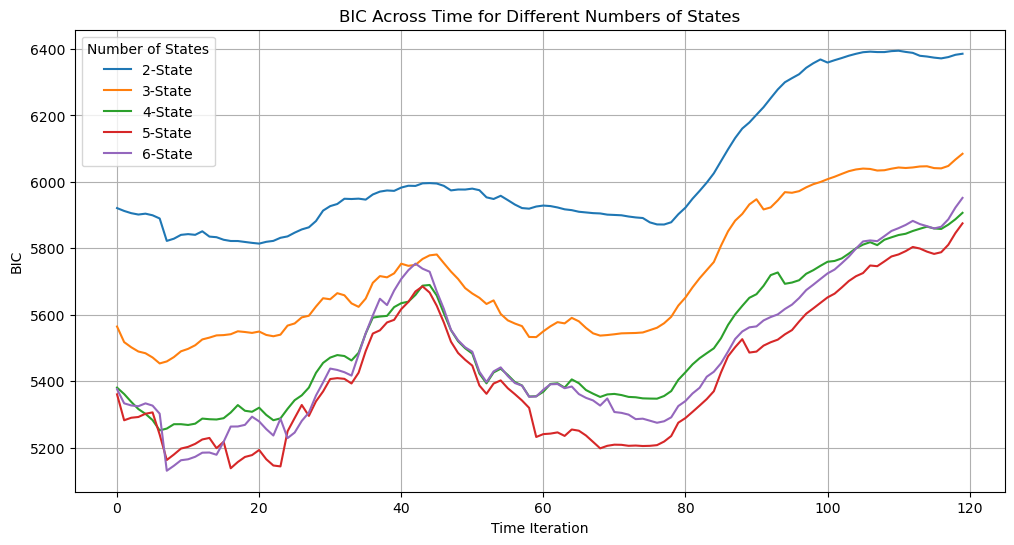

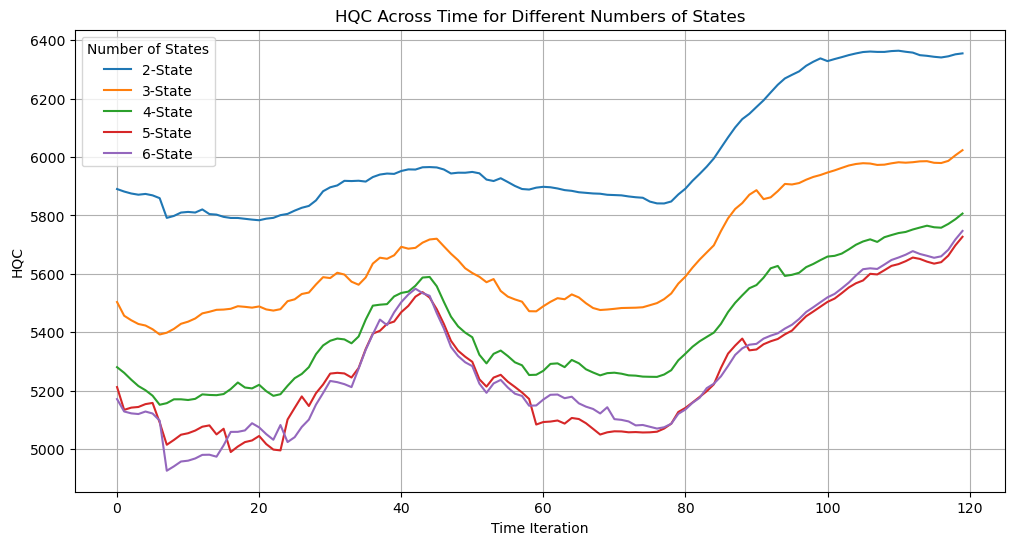

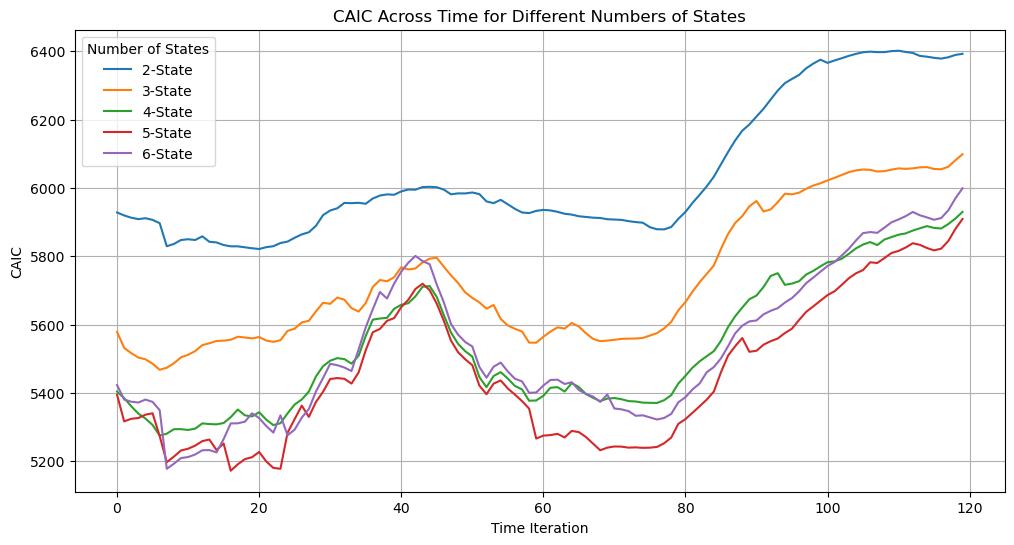

In [190]:
plt.figure(figsize=(12, 6))
# Plot AIC values for different numbers of components
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.title("AIC Across Time for Different Numbers of States")
plt.ylabel("AIC")
plt.xlabel("Time Iteration")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("AIC_plot.png", format='png', dpi=300)  # Save as PNG
plt.show()

plt.figure(figsize=(12, 6))
# Plot BIC values for different numbers of components
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.title("BIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("BIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("BIC_plot.png", format='png', dpi=300)  # Save as PNG
plt.show()

plt.figure(figsize=(12, 6))
# Plot HQC values for different numbers of components
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.title("HQC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("HQC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("HQC_plot.png", format='png', dpi=300)  # Save as PNG
plt.show()

plt.figure(figsize=(12, 6))
# Plot CAIC values for different numbers of components
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.title("CAIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("CAIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("CAIC_plot.png", format='png', dpi=300)  # Save as PNG
plt.show()

In [192]:
#Alternate method
state_range = range(2, 7)  # HMM with 2 to 6 states
best_model = None
best_criteria = {"AIC": float('inf'), "BIC": float('inf'), "HQC": float('inf'), "CAIC": float('inf')}
data_length = len(obs1)
T=120

def calculate_model_criteria(hmm_model, M, k):  # M as number of observations, k as number of parameters 
    L = hmm_model.score(obs1)  # Use the correct model passed as the argument
    aic = -2 * L + 2 * k
    bic = -2 * L + k * np.log(M)
    hqc = -2 * L + 2 * k * np.log(np.log(M))
    caic = -2 * L + k * (1 + np.log(M))
    return {"AIC": aic, "BIC": bic, "HQC": hqc, "CAIC": caic}
 
for num_states in state_range:
    model = GaussianHMM(n_components=num_states, covariance_type='diag', random_state=1)
    model.fit(obs1)

    # Number of parameters: Transition, emission, and initial probabilities
    num_params = num_states ** 2 + 2 * num_states - 1
    
    # Calculate evaluation criteria
    criteria = calculate_model_criteria(model, data_length, num_params)
    
    # Update best model based on BIC as the primary criterion
    if criteria["BIC"] < best_criteria["BIC"]:
        best_model = model
        best_criteria = criteria

print("Best Model Criteria:", best_criteria)
print(num_params)
print(num_states)

Best Model Criteria: {'AIC': 42474.26191588498, 'BIC': 42699.290630053525, 'HQC': 42560.28446583357, 'CAIC': 42746.290630053525}
47
6


# Prediction

In [199]:
# Step 6: Predict closing price
predicted_prices = []
har_model = obs1.rolling(window=10).mean().shift(1)

for i in range(len(obs1)):
    state = best_model.predict(obs1[:i + 1])[-1]  # Predict current state
    state_means = best_model.means_[state]            # Mean of observed values in the predicted state
    predicted_price = obs1.iloc[i] * (1 + state_means[-1])  # Predict price based on % change
    predicted_prices.append(predicted_price)

In [201]:
# Step 7: Evaluate predictions
predicted_prices = []

# For every observation, calculate the predicted price based on the best model
for i in range(len(obs1)):
    state = best_model.predict(obs1[:i + 1])[-1]  # Predict current state
    state_means = best_model.means_[state]  # Mean of observed values in the predicted state
    predicted_price = obs1.iloc[i] * (1 + state_means[-1])  # Predict price based on % change
    predicted_prices.append(predicted_price)


predicted_df = pd.DataFrame(predicted_prices)

# Make sure the index is a datetime index (if it's not already)
predicted_df.index = pd.to_datetime(predicted_df.index)

# Display the table
predicted_df

,Open,High,Low,Close
1950-03-01,1.318427e+03,1.318427e+03,1.318427e+03,1.318427e+03
1950-04-01,1.356334e+03,1.356334e+03,1.356334e+03,1.356334e+03
1950-05-01,1.401122e+03,1.401122e+03,1.401122e+03,1.401122e+03
1950-06-01,1.424096e+03,1.424096e+03,1.424096e+03,1.424096e+03
1950-07-01,1.321275e+03,1.321275e+03,1.321275e+03,1.321275e+03
...,...,...,...,...
2023-09-01,1.803176e+07,1.808600e+07,1.792814e+07,1.799074e+07
2023-10-01,1.743012e+07,1.753232e+07,1.731061e+07,1.742074e+07
2023-11-01,1.815536e+07,1.824469e+07,1.810922e+07,1.819871e+07
2023-12-01,1.907968e+07,1.916802e+07,1.902579e+07,1.911675e+07


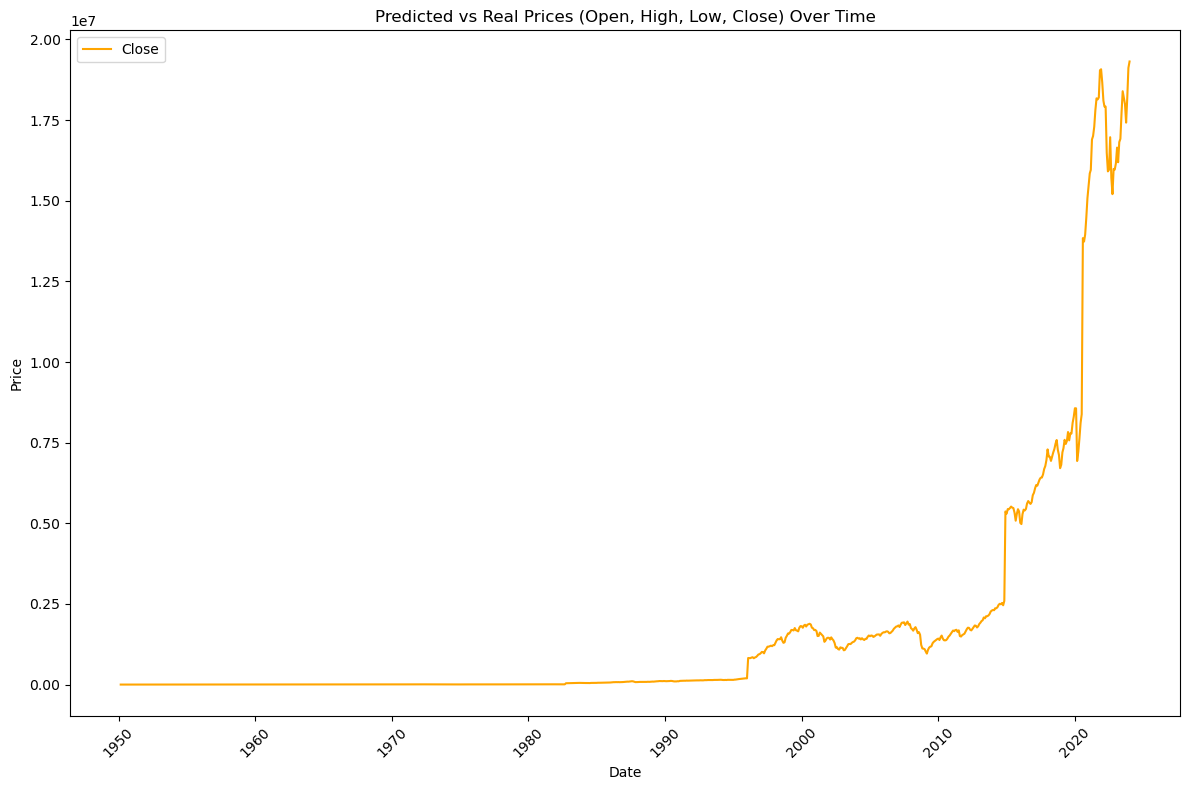

In [203]:
plt.figure(figsize=(12, 8))

plt.plot(predicted_df.index, predicted_df['Close'], label='Close', color='orange')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs Real Prices (Open, High, Low, Close) Over Time')

# Display legend
plt.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

# Evaluation

In [ ]:
# Step 7: Evaluate predictions
# do R2, RMSE, and confusion matrix?
data['Predicted_Close'] = predicted_prices
data['HAR_Close'] = har_model
data.dropna(inplace=True)

hmm_mse = mean_squared_error(data['Close'], data['Predicted_Close'])
har_mse = mean_squared_error(data['Close'], data['HAR_Close'])
print(f"HMM MSE: {hmm_mse}, HAR MSE: {har_mse}")

In [ ]:
# Step 8: Trading simulation (buy if predicted rise, sell otherwise)
data['Signal'] = np.where(data['Predicted'] > obs, 1, -1)
data['Return'] = data['Signal'] * obs.pct_change()

hmm_cumulative_return = (1 + data['Return']).cumprod()
buy_and_hold_return = (1 + obs.pct_change()).cumprod()

# Print results
print(f"HMM Cumulative Return: {hmm_cumulative_return.iloc[-1]:.2f}")
print(f"Buy-and-Hold Cumulative Return: {buy_and_hold_return.iloc[-1]:.2f}")

## failed tries idk